# Training Models

## 1. Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA

In [ ]:
# load data
data = pd.read_csv("final.csv")

In [ ]:
data.shape

(4867421, 139)

In [ ]:
data.columns

Index(['Unnamed: 0', 'crew_1', 'crew_2', 'crew_3', 'crew_4', 'crew_5',
       'crew_6', 'crew_7', 'crew_8', 'crew_13',
       ...
       'eeg_f3_gamma', 'eeg_fz_gamma', 'eeg_f4_gamma', 'eeg_c4_gamma',
       'eeg_p4_gamma', 'eeg_poz_gamma', 'eeg_c3_gamma', 'eeg_cz_gamma',
       'eeg_o2_gamma', 'y_label'],
      dtype='object', length=139)

In [ ]:
data = data.drop(["Unnamed: 0"], axis=1)

In [ ]:
# extract labels
labels = data["y_label"]
data = data.drop(["y_label"], axis=1)

## 2. PCA 
We need to first find the number of components which would have above 95% variance.

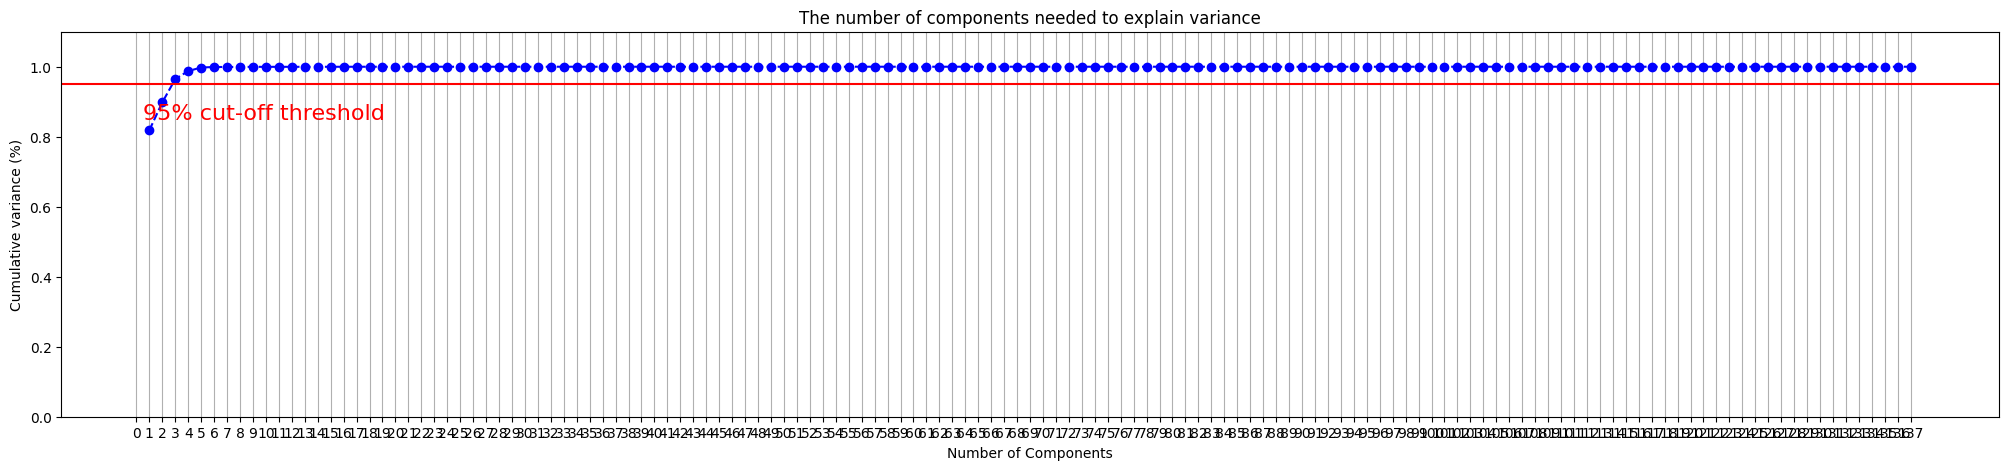

In [ ]:
# https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
pca = PCA(random_state=10).fit(data)
plt.rcParams["figure.figsize"] = (25,5)

fig, ax = plt.subplots()
xi = np.arange(1, 138, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 138, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-') #plot line where cumulative variance is 95%
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

When the number of components is 3, the variance is more than 95%.

In [ ]:
# perform PCA on all features to reduce dimensionality to 3
pca = PCA(n_components=3, random_state=10)
principalComponents = pca.fit_transform(data)
principalDf = pd.DataFrame(
                data = principalComponents, 
                columns = ['x1', 'x2', 'x3']
                )

In [ ]:
principalDf["labels"] = labels

In [ ]:
principalDf.head(5)

,x1,x2,x3,labels
0,-1266.708253,-475.322069,-435.382102,0
1,-1266.818983,-475.275942,-435.551282,0
2,-1266.929713,-475.229815,-435.720464,0
3,-1267.040443,-475.183689,-435.889641,0
4,-1267.151173,-475.137562,-436.058822,0


In [ ]:
principalDf.shape

(4867421, 4)

In [ ]:
# save data after PCA
principalDf.to_csv("pca_features.csv")

## 3. Training with 3 features

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

In [5]:
# load data
data = pd.read_csv("pca_features.csv")

In [6]:
data.head(5)

,Unnamed: 0,x1,x2,x3,labels
0,0,-1266.708253,-475.322069,-435.382102,0
1,1,-1266.818983,-475.275942,-435.551282,0
2,2,-1266.929713,-475.229815,-435.720464,0
3,3,-1267.040443,-475.183689,-435.889641,0
4,4,-1267.151173,-475.137562,-436.058822,0


In [7]:
y = data["labels"]
data = data.drop(["Unnamed: 0", "labels"], axis=1)
data.head(5)

,x1,x2,x3
0,-1266.708253,-475.322069,-435.382102
1,-1266.818983,-475.275942,-435.551282
2,-1266.929713,-475.229815,-435.720464
3,-1267.040443,-475.183689,-435.889641
4,-1267.151173,-475.137562,-436.058822


In [14]:
def plot_confusion_matrix(test_y, predict_y):
    '''
    Function to plot confusion, precision and recall matrix.
    '''
    # compute confusion matrix
    C = confusion_matrix(test_y, predict_y)
    
    # compute precision matrix
    P =(((C.T)/(C.sum(axis=1))).T)
    
    # compute recall matrix
    R =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    labels = [0, 1, 2, 3]
    
    # representing confusion matrix in heatmap format
    cmap=sns.light_palette("#79C")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    # representing precision matrix in heatmap format
    plt.subplot(1, 3, 2)
    sns.heatmap(P, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    # representing recall matrix in heatmap format
    plt.subplot(1, 3, 3)
    sns.heatmap(R, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### 3.1 Train test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, y, stratify=y, test_size=0.3, random_state=10)

In [10]:
X_train.shape, y_train.shape

((3407194, 3), (3407194,))

In [11]:
X_test.shape, y_test.shape

((1460227, 3), (1460227,))

### 3.2 Random model

In [12]:
y_train_pred = np.zeros((len(y_train),4))
y_test_pred = np.zeros((len(y_test),4))

for i in range(len(y_train)):
    rand_probs = np.random.rand(1,4)
    y_train_pred[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,4)
    y_test_pred[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
print("Log loss on Train Data using Random Model", log_loss(y_train, y_train_pred, eps=1e-15))
print("Log loss on Test Data using Random Model", log_loss(y_test, y_test_pred, eps=1e-15))

Log loss on Train Data using Random Model 1.6448170234789279
Log loss on Test Data using Random Model 1.645724042940741


This is like a baseline, our models need to have a log loss better than this at least.

### 3.3 k-NN

In [13]:
# training and  hyperparameter tuning k nearest neighbours model
knn = KNeighborsClassifier(n_jobs=-1)
parameters = {'n_neighbors':list(range(1,16))}
clf_knn = RandomizedSearchCV(knn, parameters, verbose=1)

In [14]:
clf_knn.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=KNeighborsClassifier(n_jobs=-1),
                   param_distributions={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15]},
                   verbose=1)

In [15]:
pd.DataFrame(clf_knn.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.633359,0.078175,16.481803,1.713089,7,{'n_neighbors': 7},0.940928,0.940880,0.941437,0.942015,0.941116,0.941275,0.000419,5
1,3.575948,0.039802,14.212309,0.242572,5,{'n_neighbors': 5},0.945967,0.945587,0.946214,0.946719,0.946152,0.946128,0.000367,4
2,3.574704,0.024771,14.031487,0.124432,2,{'n_neighbors': 2},0.953217,0.952744,0.953299,0.953672,0.953375,0.953261,0.000301,2
3,3.655751,0.202949,14.257706,0.308277,9,{'n_neighbors': 9},0.936744,0.936771,0.936941,0.937902,0.936916,0.937055,0.000431,7
4,3.588291,0.030043,12.378695,0.092289,1,{'n_neighbors': 1},0.960708,0.960010,0.960686,0.960726,0.960608,0.960548,0.000272,1
5,3.604769,0.036982,14.456263,0.140521,4,{'n_neighbors': 4},0.947427,0.946945,0.947653,0.947850,0.947364,0.947448,0.000305,3
6,3.562361,0.066614,14.366218,0.206277,12,{'n_neighbors': 12},0.930926,0.930956,0.931262,0.931994,0.930989,0.931225,0.000403,8
7,3.579870,0.028725,14.637543,0.112299,13,{'n_neighbors': 13},0.929633,0.929543,0.929976,0.930497,0.929584,0.929847,0.000360,9
8,3.555038,0.025673,14.526427,0.144130,8,{'n_neighbors': 8},0.938539,0.938267,0.938771,0.939613,0.938788,0.938796,0.000450,6
9,3.591033,0.046050,14.674750,0.134967,14,{'n_neighbors': 14},0.927622,0.927724,0.928205,0.928603,0.927792,0.927989,0.000365,10


In [16]:
# best parameter after hyper tuning
clf_knn.best_params_

{'n_neighbors': 1}

Log loss on Train Data using k-NN Model 6.66133814775094e-16
Log loss on Test Data using  k-NN Model 1.2603690972031818


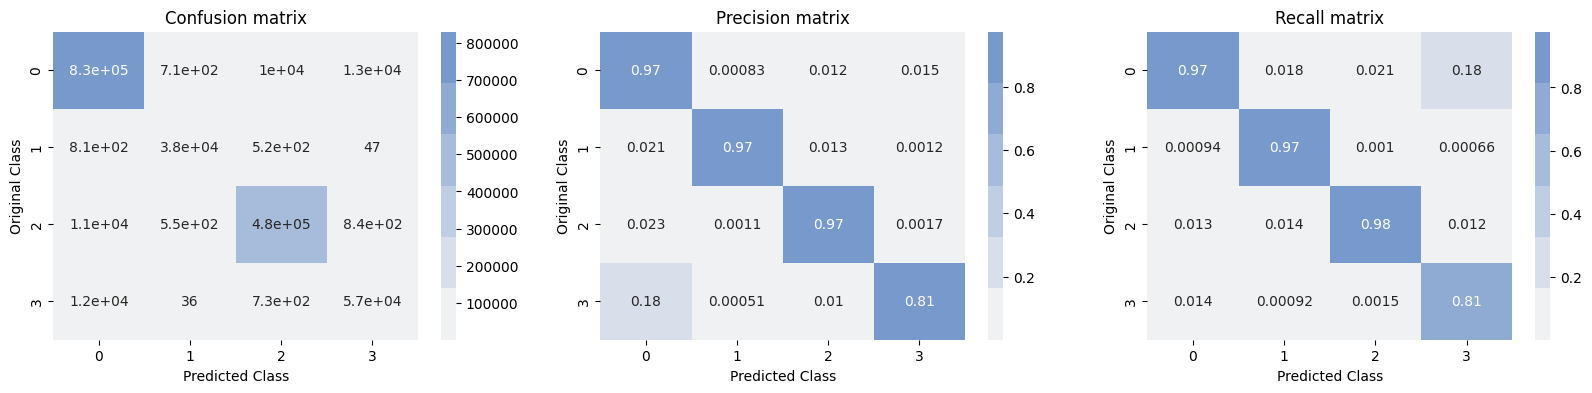

In [17]:
# predict on train and test data
y_train_pred = clf_knn.predict_proba(X_train)
y_test_pred = clf_knn.predict_proba(X_test)
print("Log loss on Train Data using k-NN Model", log_loss(y_train, y_train_pred))
print("Log loss on Test Data using  k-NN Model", log_loss(y_test, y_test_pred))


# plot confusion, precision and recall matrix
test_p_val = clf_knn.predict(X_test)
plot_confusion_matrix(y_test, test_p_val)

The test loss is better than the random model but the model is overfit. Let us try to train logistic regression.
### 3.4 Logistic regression

In [19]:
# training and  hyperparameter tuning logistic regression
log_reg = LogisticRegression(n_jobs=-1, max_iter=150)
parameters = {
    'C': list(np.arange(0.001,10,0.01)),
    'penalty': ['l1', 'l2']
}
clf_lr = RandomizedSearchCV(log_reg, param_distributions=parameters, verbose = 1)
clf_lr.fit(X_train , y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=LogisticRegression(max_iter=150, n_jobs=-1),
                   param_distributions={'C': [0.001, 0.011,
                                              0.020999999999999998,
                                              0.030999999999999996,
                                              0.040999999999999995,
                                              0.05099999999999999,
                                              0.06099999999999999, 0.071,
                                              0.08099999999999999,
                                              0.09099999999999998,
                                              0.10099999999999998,
                                              0.11099999999999999,
                                              0.12099999999999998,
                                              0.13099999999999998, 0.141,
                                              0.15099999999999997,
                                              0.16099999999999998,
                                              0.17099999999999999,
                                              0.18099999999999997,
                                              0.19099999999999998,
                                              0.20099999999999996,
                                              0.21099999999999997,
                                              0.22099999999999997,
                                              0.23099999999999996,
                                              0.24099999999999996,
                                              0.25099999999999995,
                                              0.26099999999999995,
                                              0.27099999999999996,
                                              0.28099999999999997, 0.291, ...],
                                        'penalty': ['l1', 'l2']},
                   verbose=1)

In [20]:
pd.DataFrame(clf_lr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.087921,0.006554,0.000000,0.000000,l1,0.381,"{'penalty': 'l1', 'C': 0.38099999999999995}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
1,0.087803,0.005922,0.000000,0.000000,l1,1.101,"{'penalty': 'l1', 'C': 1.1009999999999998}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
2,71.656187,5.830780,0.104666,0.002454,l2,9.561,"{'penalty': 'l2', 'C': 9.560999999999998}",0.601013,0.601024,0.600789,0.601085,0.601185,0.601019,0.000130,3
3,0.088384,0.011471,0.000000,0.000000,l1,8.441,"{'penalty': 'l1', 'C': 8.440999999999999}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
4,74.139347,2.713981,0.113667,0.023911,l2,8.541,"{'penalty': 'l2', 'C': 8.540999999999999}",0.601043,0.601033,0.600746,0.601085,0.601173,0.601016,0.000144,4
5,0.091211,0.011262,0.000000,0.000000,l1,6.841,"{'penalty': 'l1', 'C': 6.840999999999999}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
6,79.453964,2.090992,0.118855,0.023612,l2,8.201,"{'penalty': 'l2', 'C': 8.200999999999999}",0.601038,0.601022,0.600758,0.601087,0.601190,0.601019,0.000143,2
7,0.085992,0.006316,0.000000,0.000000,l1,6.911,"{'penalty': 'l1', 'C': 6.911}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
8,0.086089,0.006690,0.000000,0.000000,l1,8.041,"{'penalty': 'l1', 'C': 8.040999999999999}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
9,72.205665,5.552263,0.121032,0.025763,l2,6.521,"{'penalty': 'l2', 'C': 6.520999999999999}",0.601044,0.601038,0.600760,0.601081,0.601180,0.601021,0.000140,1


In [21]:
clf_lr.best_params_

{'penalty': 'l2', 'C': 6.520999999999999}

In [22]:
y_train_pred = clf_lr.predict_proba(X_train)
y_test_pred = clf_lr.predict_proba(X_test)

Log loss on Train Data using logistic regression Model 0.9032540335269035
Log loss on Test Data using  logistic regression Model 0.9031181593177753


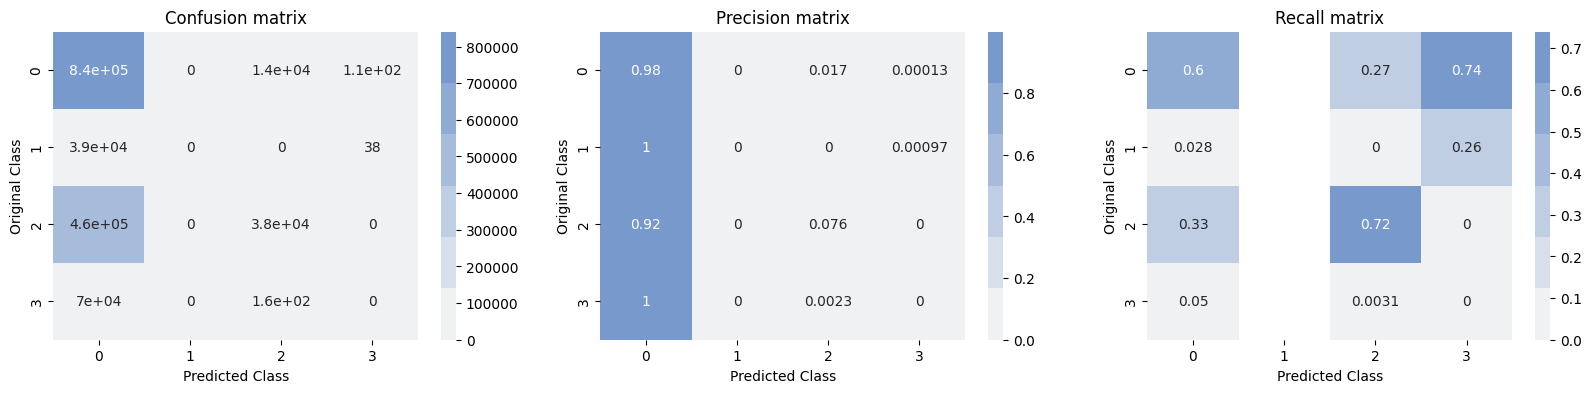

In [23]:
# predict on train and test data
y_train_pred = clf_lr.predict_proba(X_train)
y_test_pred = clf_lr.predict_proba(X_test)
print("Log loss on Train Data using logistic regression Model", log_loss(y_train, y_train_pred))
print("Log loss on Test Data using  logistic regression Model", log_loss(y_test, y_test_pred))


# plot confusion, precision and recall matrix
test_p_val = clf_lr.predict(X_test)
plot_confusion_matrix(y_test, test_p_val)

There is a bit of improvement in the log loss and the this model is not overfitting.

Let us try to train Random Forest

### 3.5 Random Forest

In [24]:
# hyper parameter tunning
params = {"n_estimators":list(range(10,500)),          
        "criterion" : ["gini","entropy"],          
        "min_samples_split" : list(range(2,50)),     
        "min_samples_leaf" :list(range(1,50)),
          }

rf = RandomForestClassifier(n_jobs=-1)
clf_rf = RandomizedSearchCV(rf,param_distributions=params,verbose=1)
clf_rf.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30, ...],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19, 20,
                                                              21, 22, 23, 24,
                                                              25, 26, 27, 28,
                                                              29, 30, 31, ...],
                                        'n_estimators': [10, 11, 12, 13, 14, 15,
                                                         16, 17, 18, 19, 20, 21,
                                                         22, 23, 24, 25, 26, 27,
                                                         28, 29, 30, 31, 32, 33,
                                                         34, 35, 36, 37, 38, 39, ...]},
                   verbose=1)

In [25]:
pd.DataFrame(clf_rf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,88.910223,2.656779,1.559549,0.007861,157,19,49,entropy,"{'n_estimators': 157, 'min_samples_split': 19,...",0.901657,0.902205,0.900899,0.902009,0.901833,0.901721,0.000449,10
1,152.319727,3.839401,3.984403,0.042367,398,48,33,gini,"{'n_estimators': 398, 'min_samples_split': 48,...",0.911995,0.912752,0.911859,0.912748,0.912086,0.912288,0.000384,6
2,82.760419,1.237005,1.465564,0.012675,143,24,44,entropy,"{'n_estimators': 143, 'min_samples_split': 24,...",0.904876,0.905201,0.904075,0.905321,0.904715,0.904838,0.000439,8
3,141.650874,1.322270,3.410264,0.038775,377,4,47,gini,"{'n_estimators': 377, 'min_samples_split': 4, ...",0.902070,0.902920,0.901567,0.902916,0.902334,0.902362,0.000517,9
4,221.194380,1.565856,4.083017,0.042308,400,35,32,entropy,"{'n_estimators': 400, 'min_samples_split': 35,...",0.913664,0.914459,0.913583,0.914408,0.913929,0.914008,0.000366,5
5,242.846885,1.316422,5.372543,0.036132,430,7,13,entropy,"{'n_estimators': 430, 'min_samples_split': 7, ...",0.935018,0.935378,0.934995,0.935668,0.935344,0.935281,0.000251,2
6,61.958812,0.279336,2.295244,0.055655,157,21,11,gini,"{'n_estimators': 157, 'min_samples_split': 21,...",0.936589,0.937120,0.936884,0.937754,0.937294,0.937128,0.000392,1
7,46.110413,0.386403,1.033731,0.012601,78,5,28,entropy,"{'n_estimators': 78, 'min_samples_split': 5, '...",0.916738,0.917504,0.916490,0.917878,0.917002,0.917122,0.000506,4
8,235.566093,0.950432,4.202288,0.019428,433,17,39,entropy,"{'n_estimators': 433, 'min_samples_split': 17,...",0.908281,0.908954,0.908065,0.909092,0.908652,0.908609,0.000389,7
9,175.662687,0.706069,5.418666,0.079291,463,21,20,gini,"{'n_estimators': 463, 'min_samples_split': 21,...",0.924577,0.925238,0.924511,0.925424,0.924758,0.924902,0.000364,3


In [26]:
clf_rf.best_params_

{'n_estimators': 157,
 'min_samples_split': 21,
 'min_samples_leaf': 11,
 'criterion': 'gini'}

Log loss on Train Data using Random Forest Model 0.13594677990784695
Log loss on Test Data using  Random Forest Model 0.16531410191742293


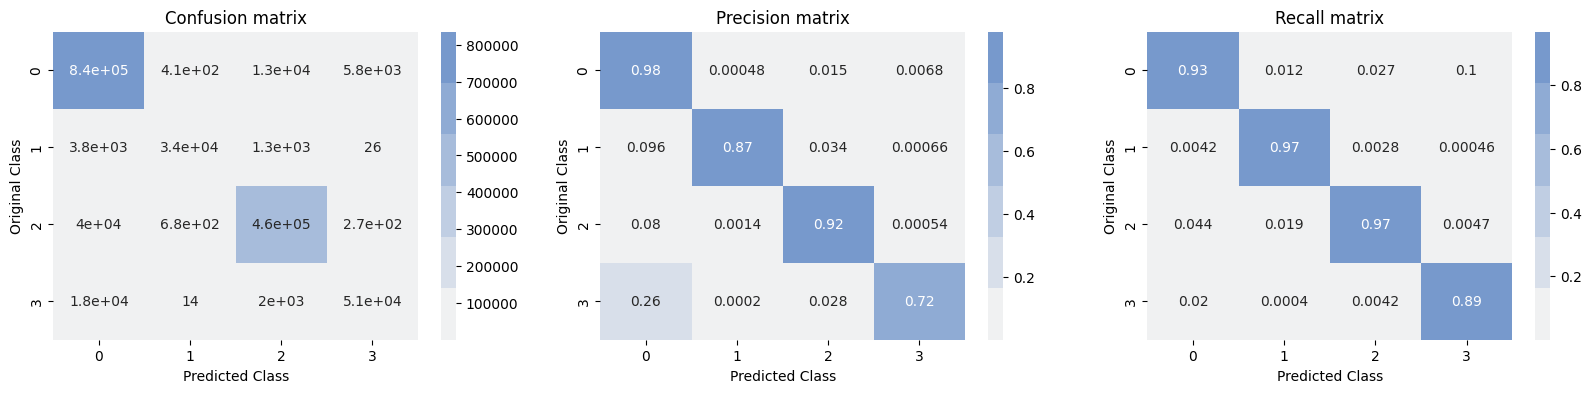

In [27]:
# predict on train and test data
y_train_pred = clf_rf.predict_proba(X_train)
y_test_pred = clf_rf.predict_proba(X_test)
print("Log loss on Train Data using Random Forest Model", log_loss(y_train, y_train_pred))
print("Log loss on Test Data using  Random Forest Model", log_loss(y_test, y_test_pred))


# plot confusion, precision and recall matrix
test_p_val = clf_rf.predict(X_test)
plot_confusion_matrix(y_test, test_p_val)

There is a significant reduction in the log loss when compared to logistic regression. There is almost 0.7 difference between test and train loss.

Let us try to train LGBM.

### 3.6 LGBM

In [32]:
#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
# training and hyper parameter tunning LGBM
params = {"n_estimators":list(range(10,500)),          
        "num_leaves" : range(1,50),          
        "learning_rate" : [1e-4,0.0001,0.001,0.01,0.1],     
        "bagging_fraction" : list(np.arange(0.0,1.0,0.1)),                    
        "colsample_bytree" : list(np.arange(0.0,1.0,0.1)),  
        'min_data_in_leaf':list(range(10,100))
          }

lgbm = lgb.LGBMClassifier(n_jobs=-1) 
clf_lgbm = RandomizedSearchCV(lgbm,param_distributions=params,verbose=1)
clf_lgbm.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min

[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 356 .



[LightGBM] [Warning] bagging_fraction is set=0.0, subsample=1.0 will be ignored. Current value: bagging_fraction=0.0
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 356 .



[LightGBM] [Warning] bagging_fraction is set=0.0, subsample=1.0 will be ignored. Current value: bagging_fraction=0.0
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 356 .



[LightGBM] [Warning] bagging_fraction is set=0.0, subsample=1.0 will be ignored. Current value: bagging_fraction=0.0
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 356 .



[LightGBM] [Warning] bagging_fraction is set=0.0, subsample=1.0 will be ignored. Current value: bagging_fraction=0.0
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 356 .



[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] bagging_fraction is set

[LightGBM] [Fatal] Check failed: (feature_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 372 .



[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[LightGBM] [Fatal] Check failed: (feature_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 372 .



[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[LightGBM] [Fatal] Check failed: (feature_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 372 .



[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[LightGBM] [Fatal] Check failed: (feature_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 372 .



[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[LightGBM] [Fatal] Check failed: (feature_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 372 .



[LightGBM] [Warning] bagging_fraction is set=0.0, subsample=1.0 will be ignored. Current value: bagging_fraction=0.0
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 356 .



[LightGBM] [Warning] bagging_fraction is set=0.0, subsample=1.0 will be ignored. Current value: bagging_fraction=0.0
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 356 .



[LightGBM] [Warning] bagging_fraction is set=0.0, subsample=1.0 will be ignored. Current value: bagging_fraction=0.0
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 356 .



[LightGBM] [Warning] bagging_fraction is set=0.0, subsample=1.0 will be ignored. Current value: bagging_fraction=0.0
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 356 .



[LightGBM] [Warning] bagging_fraction is set=0.0, subsample=1.0 will be ignored. Current value: bagging_fraction=0.0
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[LightGBM] [Fatal] Check failed: (bagging_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 356 .



[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] bagging_fraction is set

RandomizedSearchCV(estimator=LGBMClassifier(),
                   param_distributions={'bagging_fraction': [0.0, 0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5,
                                                             0.6000000000000001,
                                                             0.7000000000000001,
                                                             0.8, 0.9],
                                        'colsample_bytree': [0.0, 0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5,
                                                             0.6000000000000001,
                                                             0.7000000000000001,
                                                             0.8, 0.9],
                                        'learning_rate': [0.0001, 0.0001, 0.001,
                                                          0.01, 0.1],
                                        'min_data_in_leaf': [10, 11, 12, 13, 14,
                                                             15, 16, 17, 18, 19,
                                                             20, 21, 22, 23, 24,
                                                             25, 26, 27, 28, 29,
                                                             30, 31, 32, 33, 34,
                                                             35, 36, 37, 38, 39, ...],
                                        'n_estimators': [10, 11, 12, 13, 14, 15,
                                                         16, 17, 18, 19, 20, 21,
                                                         22, 23, 24, 25, 26, 27,
                                                         28, 29, 30, 31, 32, 33,
                                                         34, 35, 36, 37, 38, 39, ...],
                                        'num_leaves': range(1, 50)},
                   verbose=1)

In [33]:
pd.DataFrame(clf_lgbm.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_min_data_in_leaf,param_learning_rate,param_colsample_bytree,param_bagging_fraction,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,22.658603,0.676930,2.354004,0.017533,6,380,75,0.1,0.7,0.8,"{'num_leaves': 6, 'n_estimators': 380, 'min_da...",0.734826,0.735752,0.734871,0.735783,0.734696,0.735186,4.784676e-04,2
1,0.299158,0.005773,0.000000,0.000000,4,389,95,0.001,0.6,0.0,"{'num_leaves': 4, 'n_estimators': 389, 'min_da...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
2,28.212078,7.643799,2.354506,0.009894,30,258,56,0.001,0.5,0.9,"{'num_leaves': 30, 'n_estimators': 258, 'min_d...",0.651809,0.650920,0.649572,0.648391,0.649598,0.650058,1.186043e-03,5
3,10.373977,2.933363,0.382231,0.006350,4,167,94,0.0001,0.5,0.1,"{'num_leaves': 4, 'n_estimators': 167, 'min_da...",0.585282,0.585281,0.585281,0.585281,0.585281,0.585281,6.014642e-07,6
4,7.118561,0.131244,0.320685,0.002723,48,61,66,0.0001,0.8,0.5,"{'num_leaves': 48, 'n_estimators': 61, 'min_da...",0.585282,0.585281,0.585281,0.585281,0.585281,0.585281,6.014642e-07,6
5,0.289260,0.003500,0.000000,0.000000,49,499,82,0.01,0.0,0.3,"{'num_leaves': 49, 'n_estimators': 499, 'min_d...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
6,0.288208,0.004078,0.000000,0.000000,49,266,88,0.0001,0.2,0.0,"{'num_leaves': 49, 'n_estimators': 266, 'min_d...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
7,12.185689,0.250636,0.977992,0.019168,35,120,43,0.1,0.4,0.5,"{'num_leaves': 35, 'n_estimators': 120, 'min_d...",0.686188,0.688546,0.686879,0.687549,0.687167,0.687266,7.798631e-04,3
8,12.688823,0.205996,0.910099,0.011562,31,124,86,0.1,0.6,0.3,"{'num_leaves': 31, 'n_estimators': 124, 'min_d...",0.760363,0.759497,0.760764,0.759915,0.760784,0.760265,4.978244e-04,1
9,3.527930,0.502809,0.277797,0.010314,12,39,61,0.1,0.2,0.1,"{'num_leaves': 12, 'n_estimators': 39, 'min_da...",0.663901,0.663607,0.666415,0.664779,0.663713,0.664483,1.050507e-03,4


In [34]:
clf_lgbm.best_params_

{'num_leaves': 31,
 'n_estimators': 124,
 'min_data_in_leaf': 86,
 'learning_rate': 0.1,
 'colsample_bytree': 0.6000000000000001,
 'bagging_fraction': 0.30000000000000004}

Log loss on Train Data using LGBM Model 0.5349249073282395
Log loss on Test Data using  LGBM Model 0.5343996967595405


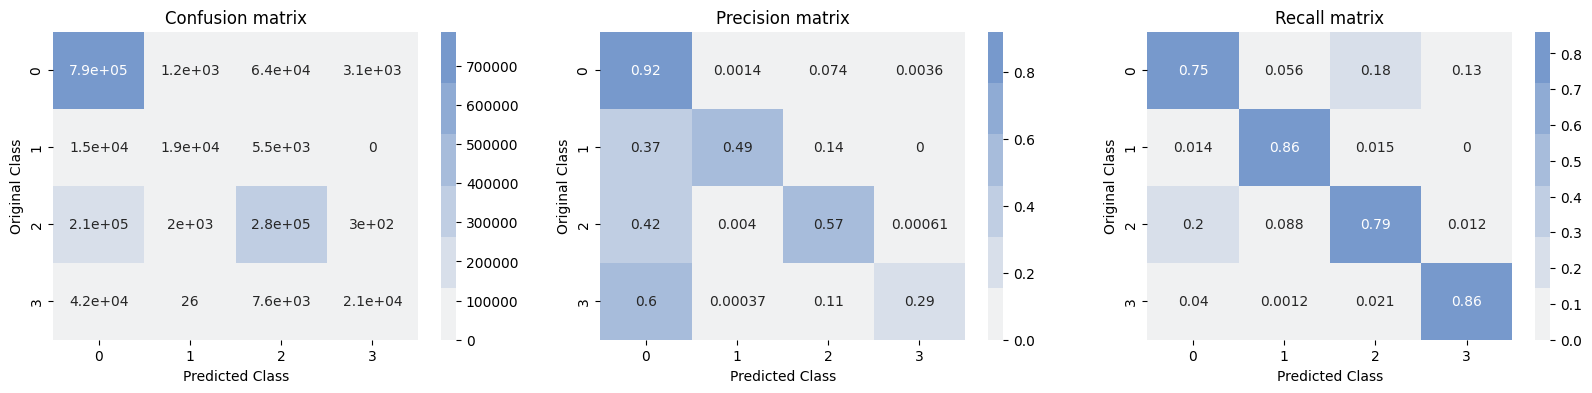

In [35]:
# predict on train and test data
y_train_pred = clf_lgbm.predict_proba(X_train)
y_test_pred = clf_lgbm.predict_proba(X_test)
print("Log loss on Train Data using LGBM Model", log_loss(y_train, y_train_pred))
print("Log loss on Test Data using  LGBM Model", log_loss(y_test, y_test_pred))


# plot confusion, precision and recall matrix
test_p_val = clf_lgbm.predict(X_test)
plot_confusion_matrix(y_test, test_p_val)

The test loss is more when compared to random forest model.
Also, there is no overfit in LGBM model.

Let us try to reduce number of components to 4 instead of 3 and train the models.

## 4. Training with 4 features
### 4.1 PCA

In [ ]:
# perform PCA on all features to reduce dimensionality to 4
pca = PCA(n_components=4, random_state=10)
principalComponents = pca.fit_transform(data)
principalDf = pd.DataFrame(
                data = principalComponents, 
                columns = ['x1', 'x2', 'x3', 'x4']
                )

In [ ]:
principalDf["labels"] = labels

In [ ]:
principalDf.head(5)

,x1,x2,x3,x4,labels
0,-1266.708253,-475.322069,-435.382102,5.755594,0
1,-1266.818983,-475.275942,-435.551282,5.717333,0
2,-1266.929713,-475.229815,-435.720464,5.679077,0
3,-1267.040443,-475.183689,-435.889641,5.640808,0
4,-1267.151173,-475.137562,-436.058822,5.602549,0


In [ ]:
principalDf.shape

(4867421, 5)

In [ ]:
# save data with 4 features
principalDf.to_csv("pca_features_v2.csv")

In [3]:
# load data
data = pd.read_csv("pca_features_v2.csv")

In [4]:
data.head(5)

,Unnamed: 0,x1,x2,x3,x4,labels
0,0,-1266.708253,-475.322069,-435.382102,5.755594,0
1,1,-1266.818983,-475.275942,-435.551282,5.717333,0
2,2,-1266.929713,-475.229815,-435.720464,5.679077,0
3,3,-1267.040443,-475.183689,-435.889641,5.640808,0
4,4,-1267.151173,-475.137562,-436.058822,5.602549,0


In [5]:
y = data["labels"]
data = data.drop(["Unnamed: 0", "labels"], axis=1)
data.head(5)

,x1,x2,x3,x4
0,-1266.708253,-475.322069,-435.382102,5.755594
1,-1266.818983,-475.275942,-435.551282,5.717333
2,-1266.929713,-475.229815,-435.720464,5.679077
3,-1267.040443,-475.183689,-435.889641,5.640808
4,-1267.151173,-475.137562,-436.058822,5.602549


### 4.3 Train test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, y, stratify=y, test_size=0.3, random_state=10)

In [7]:
X_train.shape, y_train.shape

((3407194, 4), (3407194,))

In [8]:
X_test.shape, y_test.shape

((1460227, 4), (1460227,))

### 4.3 Random model

In [42]:
y_train_pred = np.zeros((len(y_train),4))
y_test_pred = np.zeros((len(y_test),4))

for i in range(len(y_train)):
    rand_probs = np.random.rand(1,4)
    y_train_pred[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,4)
    y_test_pred[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
print("Log loss on Train Data using Random Model", log_loss(y_train, y_train_pred, eps=1e-15))
print("Log loss on Test Data using Random Model", log_loss(y_test, y_test_pred, eps=1e-15))

Log loss on Train Data using Random Model 1.6451765891005423
Log loss on Test Data using Random Model 1.6455501013611864


This is like a baseline, our models need to have a log loss better than this at least.

### 4.4 k-NN

In [43]:
# training and  hyperparameter tuning k nearest neighbours model
knn = KNeighborsClassifier(n_jobs=-1)
parameters = {'n_neighbors':list(range(1,16))}
clf_knn = RandomizedSearchCV(knn, parameters, verbose=1)

In [44]:
clf_knn.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=KNeighborsClassifier(n_jobs=-1),
                   param_distributions={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15]},
                   verbose=1)

In [45]:
pd.DataFrame(clf_knn.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.492502,0.242276,15.884594,2.754265,15,{'n_neighbors': 15},0.945951,0.946038,0.946431,0.946782,0.946117,0.946264,0.000306,10
1,4.415642,0.070275,14.435495,0.107001,14,{'n_neighbors': 14},0.947061,0.947162,0.947909,0.948044,0.947238,0.947483,0.000409,9
2,4.338966,0.056050,13.918599,0.183409,4,{'n_neighbors': 4},0.966409,0.966348,0.966782,0.966990,0.966835,0.966673,0.000251,3
3,4.363990,0.054178,14.249034,0.147737,10,{'n_neighbors': 10},0.954333,0.953911,0.954680,0.954645,0.954373,0.954388,0.000276,7
4,4.288633,0.058825,14.213599,0.426740,9,{'n_neighbors': 9},0.956373,0.956232,0.957059,0.957056,0.956758,0.956695,0.000342,6
5,4.331250,0.027031,14.384910,0.129135,13,{'n_neighbors': 13},0.949183,0.949150,0.949730,0.949946,0.949366,0.949475,0.000313,8
6,4.481423,0.204453,13.876143,0.159708,3,{'n_neighbors': 3},0.968119,0.967982,0.968429,0.968635,0.968550,0.968343,0.000251,2
7,4.323566,0.046854,14.213533,0.188826,8,{'n_neighbors': 8},0.957971,0.957932,0.958475,0.958654,0.958363,0.958279,0.000283,5
8,4.352941,0.047805,13.746942,0.124778,2,{'n_neighbors': 2},0.971267,0.971055,0.971185,0.971719,0.971314,0.971308,0.000223,1
9,4.336480,0.042956,13.918500,0.126791,5,{'n_neighbors': 5},0.964795,0.964893,0.965250,0.965658,0.965502,0.965220,0.000335,4


In [46]:
# best parameter after hyper tuning
clf_knn.best_params_

{'n_neighbors': 2}

Log loss on Train Data using k-NN Model 0.01632047937782329
Log loss on Test Data using  k-NN Model 0.5411128429359723


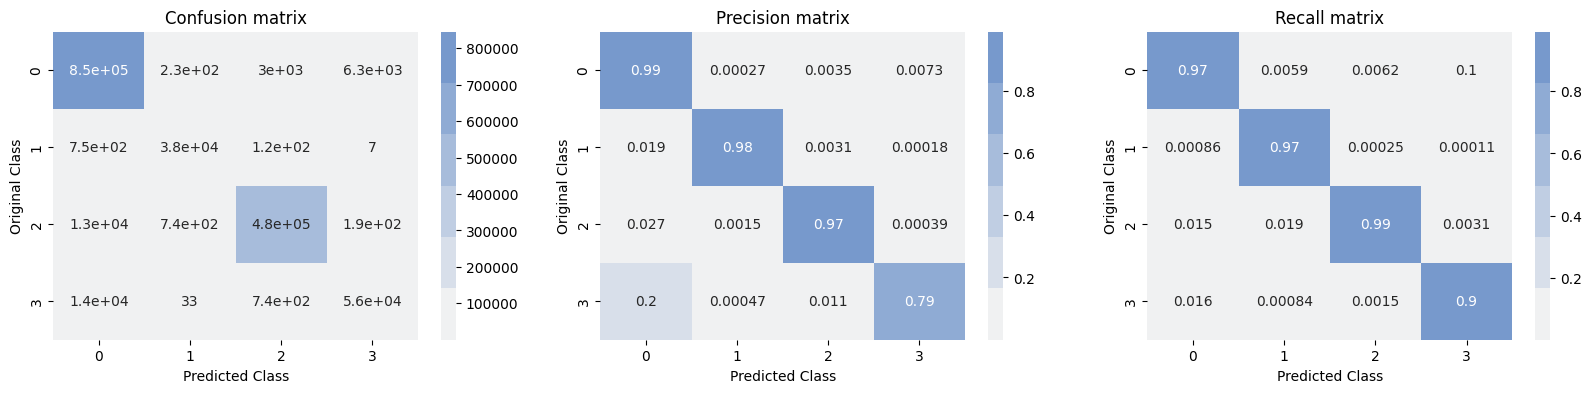

In [47]:
# predict on train and test data
y_train_pred = clf_knn.predict_proba(X_train)
y_test_pred = clf_knn.predict_proba(X_test)
print("Log loss on Train Data using k-NN Model", log_loss(y_train, y_train_pred))
print("Log loss on Test Data using  k-NN Model", log_loss(y_test, y_test_pred))


# plot confusion, precision and recall matrix
test_p_val = clf_knn.predict(X_test)
plot_confusion_matrix(y_test, test_p_val)

The test loss is better than the random model but the model is overfit. Let us try to train logistic regression.
### 4.5 Logistic regression

In [55]:
# training and  hyperparameter tuning logistic regression
log_reg = LogisticRegression(n_jobs=-1, max_iter=1500)
parameters = {
    'C': list(np.arange(0.001,10,0.01)),
    'penalty': ['l1', 'l2']
}
clf_lr = RandomizedSearchCV(log_reg, param_distributions=parameters, verbose = 1)
clf_lr.fit(X_train , y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=LogisticRegression(max_iter=1500, n_jobs=-1),
                   param_distributions={'C': [0.001, 0.011,
                                              0.020999999999999998,
                                              0.030999999999999996,
                                              0.040999999999999995,
                                              0.05099999999999999,
                                              0.06099999999999999, 0.071,
                                              0.08099999999999999,
                                              0.09099999999999998,
                                              0.10099999999999998,
                                              0.11099999999999999,
                                              0.12099999999999998,
                                              0.13099999999999998, 0.141,
                                              0.15099999999999997,
                                              0.16099999999999998,
                                              0.17099999999999999,
                                              0.18099999999999997,
                                              0.19099999999999998,
                                              0.20099999999999996,
                                              0.21099999999999997,
                                              0.22099999999999997,
                                              0.23099999999999996,
                                              0.24099999999999996,
                                              0.25099999999999995,
                                              0.26099999999999995,
                                              0.27099999999999996,
                                              0.28099999999999997, 0.291, ...],
                                        'penalty': ['l1', 'l2']},
                   verbose=1)

In [56]:
pd.DataFrame(clf_lr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,225.680012,30.174342,0.118454,0.023650,l2,4.331,"{'penalty': 'l2', 'C': 4.3309999999999995}",0.618453,0.618290,0.617873,0.618327,0.617923,0.618173,0.000232,6
1,227.882943,24.920571,0.107959,0.022810,l2,2.501,"{'penalty': 'l2', 'C': 2.5009999999999994}",0.618193,0.618440,0.617923,0.618531,0.618188,0.618255,0.000214,1
2,0.081790,0.005882,0.000000,0.000000,l1,4.191,"{'penalty': 'l1', 'C': 4.191}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
3,227.626606,12.265985,0.090149,0.013011,l2,0.071,"{'penalty': 'l2', 'C': 0.071}",0.618252,0.618161,0.618124,0.618416,0.618149,0.618220,0.000107,5
4,241.959764,32.685092,0.112963,0.025891,l2,9.671,"{'penalty': 'l2', 'C': 9.670999999999998}",0.618419,0.618233,0.617935,0.618365,0.618254,0.618241,0.000168,4
5,0.080771,0.005723,0.000000,0.000000,l1,2.981,"{'penalty': 'l1', 'C': 2.9809999999999994}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
6,0.077540,0.001418,0.000000,0.000000,l1,2.541,"{'penalty': 'l1', 'C': 2.5409999999999995}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
7,225.155956,30.375014,0.128402,0.028751,l2,9.061,"{'penalty': 'l2', 'C': 9.060999999999998}",0.618321,0.618353,0.617803,0.618403,0.618345,0.618245,0.000223,2
8,230.261960,46.647793,0.106083,0.020460,l2,8.331,"{'penalty': 'l2', 'C': 8.330999999999998}",0.618400,0.618217,0.618073,0.618344,0.618185,0.618244,0.000117,3
9,0.078396,0.005968,0.000000,0.000000,l1,6.521,"{'penalty': 'l1', 'C': 6.520999999999999}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


In [57]:
clf_lr.best_params_

{'penalty': 'l2', 'C': 2.5009999999999994}

In [58]:
y_train_pred = clf_lr.predict_proba(X_train)
y_test_pred = clf_lr.predict_proba(X_test)

Log loss on Train Data using logistic regression Model 0.8834052565648282
Log loss on Test Data using  logistic regression Model 0.8830098547691825


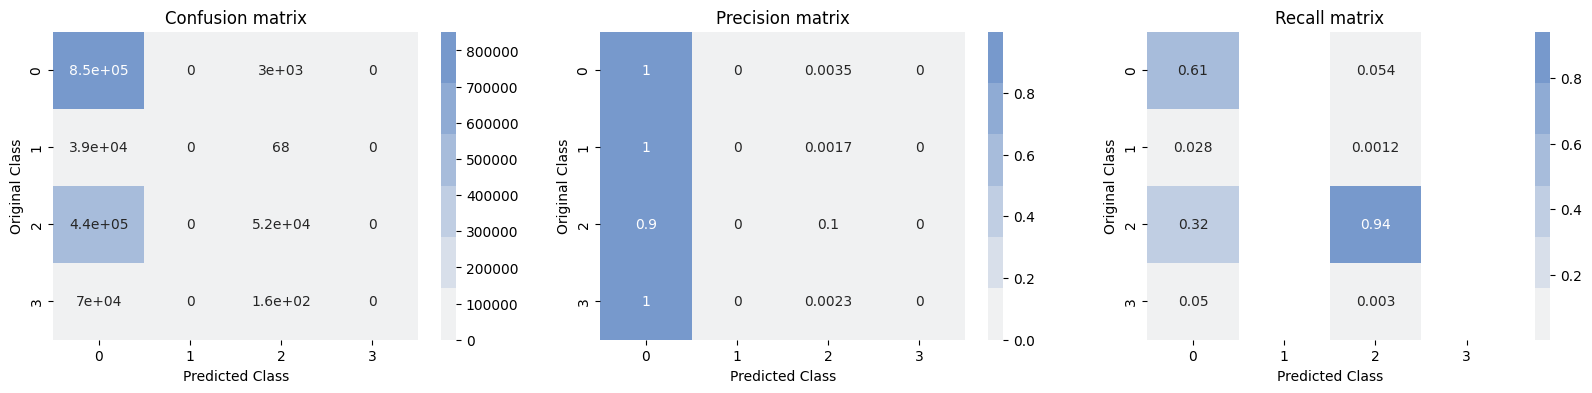

In [59]:
# predict on train and test data
y_train_pred = clf_lr.predict_proba(X_train)
y_test_pred = clf_lr.predict_proba(X_test)
print("Log loss on Train Data using logistic regression Model", log_loss(y_train, y_train_pred))
print("Log loss on Test Data using  logistic regression Model", log_loss(y_test, y_test_pred))


# plot confusion, precision and recall matrix
test_p_val = clf_lr.predict(X_test)
plot_confusion_matrix(y_test, test_p_val)

### 4.6 Random Forest

In [60]:
# hyper parameter tunning
params = {"n_estimators":list(range(10,500)),          
        "criterion" : ["gini","entropy"],
        "min_samples_split" : list(range(2,100)),     
        "min_samples_leaf" :list(range(1,100)),
          }

rf = RandomForestClassifier(n_jobs=-1)
clf_rf = RandomizedSearchCV(rf,param_distributions=params,verbose=1)
clf_rf.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30, ...],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19, 20,
                                                              21, 22, 23, 24,
                                                              25, 26, 27, 28,
                                                              29, 30, 31, ...],
                                        'n_estimators': [10, 11, 12, 13, 14, 15,
                                                         16, 17, 18, 19, 20, 21,
                                                         22, 23, 24, 25, 26, 27,
                                                         28, 29, 30, 31, 32, 33,
                                                         34, 35, 36, 37, 38, 39, ...]},
                   verbose=1)

In [61]:
pd.DataFrame(clf_rf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,133.636685,2.176097,1.254581,0.017521,115,51,19,entropy,"{'n_estimators': 115, 'min_samples_split': 51,...",0.949231,0.949466,0.949743,0.950197,0.949780,0.949683,0.000325,3
1,36.991580,1.212732,0.438074,0.006431,21,81,27,entropy,"{'n_estimators': 21, 'min_samples_split': 81, ...",0.937032,0.937459,0.937566,0.938361,0.937978,0.937679,0.000455,4
2,80.587508,2.007821,0.978280,0.013658,107,46,65,gini,"{'n_estimators': 107, 'min_samples_split': 46,...",0.917529,0.917968,0.917122,0.918195,0.917372,0.917637,0.000392,7
3,481.839121,1.913033,3.205852,0.015152,460,43,80,entropy,"{'n_estimators': 460, 'min_samples_split': 43,...",0.911958,0.912563,0.911798,0.912664,0.912337,0.912264,0.000336,9
4,233.372717,0.705128,2.900230,0.016113,333,25,38,gini,"{'n_estimators': 333, 'min_samples_split': 25,...",0.933310,0.933922,0.933871,0.934408,0.933758,0.933854,0.000351,5
5,224.459428,4.438940,3.407255,0.032713,316,17,11,gini,"{'n_estimators': 316, 'min_samples_split': 17,...",0.960852,0.961135,0.961437,0.961643,0.961345,0.961283,0.000270,1
6,411.936535,0.851552,3.768607,0.035231,374,5,15,entropy,"{'n_estimators': 374, 'min_samples_split': 5, ...",0.957653,0.957845,0.957998,0.958444,0.958067,0.958001,0.000263,2
7,337.735358,1.694268,3.520651,0.020700,499,14,80,gini,"{'n_estimators': 499, 'min_samples_split': 14,...",0.911094,0.911503,0.910864,0.911546,0.911128,0.911227,0.000260,10
8,310.168640,1.559286,2.169779,0.042163,290,45,74,entropy,"{'n_estimators': 290, 'min_samples_split': 45,...",0.914557,0.915011,0.914459,0.915133,0.914999,0.914832,0.000270,8
9,84.807898,0.881189,0.800283,0.008222,75,86,51,entropy,"{'n_estimators': 75, 'min_samples_split': 86, ...",0.926015,0.926679,0.926503,0.927129,0.926502,0.926566,0.000358,6


In [62]:
clf_rf.best_params_

{'n_estimators': 316,
 'min_samples_split': 17,
 'min_samples_leaf': 11,
 'criterion': 'gini'}

Log loss on Train Data using Random Forest Model 0.08286004520119074
Log loss on Test Data using  Random Forest Model 0.10427127286691444


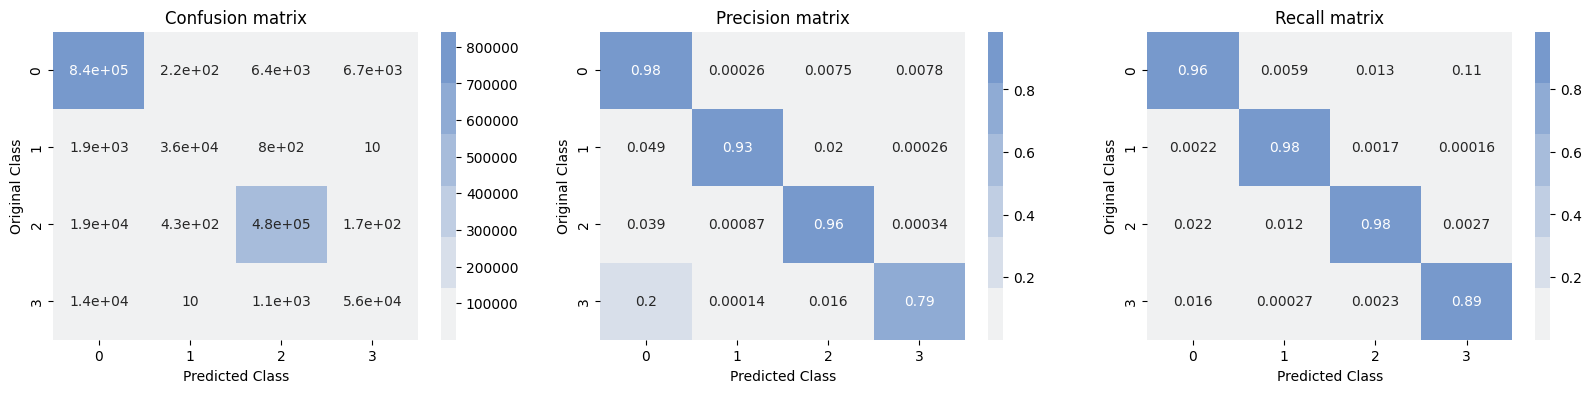

In [63]:
# predict on train and test data
y_train_pred = clf_rf.predict_proba(X_train)
y_test_pred = clf_rf.predict_proba(X_test)
print("Log loss on Train Data using Random Forest Model", log_loss(y_train, y_train_pred))
print("Log loss on Test Data using  Random Forest Model", log_loss(y_test, y_test_pred))


# plot confusion, precision and recall matrix
test_p_val = clf_rf.predict(X_test)
plot_confusion_matrix(y_test, test_p_val)

### 4.7 LGBM

In [64]:
#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
# hyper parameter tunning
params = {"n_estimators":list(range(10,500)),          
        "num_leaves" : range(1,50),          
        "learning_rate" : [1e-4,0.0001,0.001,0.01,0.1],     
        "bagging_fraction" : list(np.arange(0.0,1.0,0.1)),                    
        "colsample_bytree" : list(np.arange(0.0,1.0,0.1)),  
        'min_data_in_leaf':list(range(10,100))
          }

In [65]:
lgbm = lgb.LGBMClassifier(n_jobs=-1) 
clf_lgbm = RandomizedSearchCV(lgbm,param_distributions=params,verbose=1)

In [66]:
clf_lgbm.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fracti

[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


[LightGBM] [Fatal] Check failed: (feature_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 372 .



[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


[LightGBM] [Fatal] Check failed: (feature_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 372 .



[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


[LightGBM] [Fatal] Check failed: (feature_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 372 .



[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


[LightGBM] [Fatal] Check failed: (feature_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 372 .



[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


[LightGBM] [Fatal] Check failed: (feature_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 372 .



[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=3

RandomizedSearchCV(estimator=LGBMClassifier(),
                   param_distributions={'bagging_fraction': [0.0, 0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5,
                                                             0.6000000000000001,
                                                             0.7000000000000001,
                                                             0.8, 0.9],
                                        'colsample_bytree': [0.0, 0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5,
                                                             0.6000000000000001,
                                                             0.7000000000000001,
                                                             0.8, 0.9],
                                        'learning_rate': [0.0001, 0.0001, 0.001,
                                                          0.01, 0.1],
                                        'min_data_in_leaf': [10, 11, 12, 13, 14,
                                                             15, 16, 17, 18, 19,
                                                             20, 21, 22, 23, 24,
                                                             25, 26, 27, 28, 29,
                                                             30, 31, 32, 33, 34,
                                                             35, 36, 37, 38, 39, ...],
                                        'n_estimators': [10, 11, 12, 13, 14, 15,
                                                         16, 17, 18, 19, 20, 21,
                                                         22, 23, 24, 25, 26, 27,
                                                         28, 29, 30, 31, 32, 33,
                                                         34, 35, 36, 37, 38, 39, ...],
                                        'num_leaves': range(1, 50)},
                   verbose=1)

In [67]:
pd.DataFrame(clf_lgbm.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_min_data_in_leaf,param_learning_rate,param_colsample_bytree,param_bagging_fraction,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,43.398587,11.472114,3.518460,0.083729,24,393,49,0.0001,0.8,0.3,"{'num_leaves': 24, 'n_estimators': 393, 'min_d...",0.585282,0.585281,0.585281,0.585281,0.585281,0.585281,6.014642e-07,6
1,39.032678,0.823018,3.810304,0.047929,33,344,37,0.01,0.8,0.8,"{'num_leaves': 33, 'n_estimators': 344, 'min_d...",0.768858,0.768939,0.769112,0.769643,0.768303,0.768971,4.316639e-04,2
2,28.701630,0.342547,2.711579,0.014578,32,286,37,0.001,0.5,0.4,"{'num_leaves': 32, 'n_estimators': 286, 'min_d...",0.663527,0.664105,0.661186,0.661481,0.661676,0.662395,1.184796e-03,3
3,2.710301,0.013932,0.137477,0.005320,2,51,97,0.001,0.3,0.5,"{'num_leaves': 2, 'n_estimators': 51, 'min_dat...",0.585282,0.585281,0.585281,0.585281,0.585281,0.585281,6.014642e-07,6
4,25.253742,5.241458,2.703867,0.011091,25,277,15,0.1,0.4,0.5,"{'num_leaves': 25, 'n_estimators': 277, 'min_d...",0.802638,0.803770,0.803106,0.803514,0.802666,0.803139,4.504058e-04,1
5,18.097008,1.475423,1.019069,0.047020,44,146,70,0.0001,0.9,0.9,"{'num_leaves': 44, 'n_estimators': 146, 'min_d...",0.585282,0.585281,0.585281,0.585281,0.585281,0.585281,6.014642e-07,6
6,2.533515,0.608317,0.137232,0.004054,27,21,69,0.01,0.2,0.3,"{'num_leaves': 27, 'n_estimators': 21, 'min_da...",0.590867,0.585281,0.590932,0.585281,0.585281,0.587528,2.752668e-03,5
7,0.307835,0.005770,0.000000,0.000000,24,419,76,0.1,0.0,0.2,"{'num_leaves': 24, 'n_estimators': 419, 'min_d...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
8,15.649101,1.170868,1.069991,0.048841,36,148,33,0.001,0.5,0.6,"{'num_leaves': 36, 'n_estimators': 148, 'min_d...",0.585282,0.585281,0.585281,0.585281,0.585281,0.585281,6.014642e-07,6
9,17.775636,0.341475,1.812149,0.006766,31,192,26,0.01,0.3,0.2,"{'num_leaves': 31, 'n_estimators': 192, 'min_d...",0.645792,0.647226,0.646863,0.646717,0.647641,0.646848,6.169945e-04,4


In [68]:
clf_lgbm.best_params_

{'num_leaves': 25,
 'n_estimators': 277,
 'min_data_in_leaf': 15,
 'learning_rate': 0.1,
 'colsample_bytree': 0.4,
 'bagging_fraction': 0.5}

Log loss on Train Data using LGBM Model 0.43531021867824976
Log loss on Test Data using  LGBM Model 0.4357754425591687


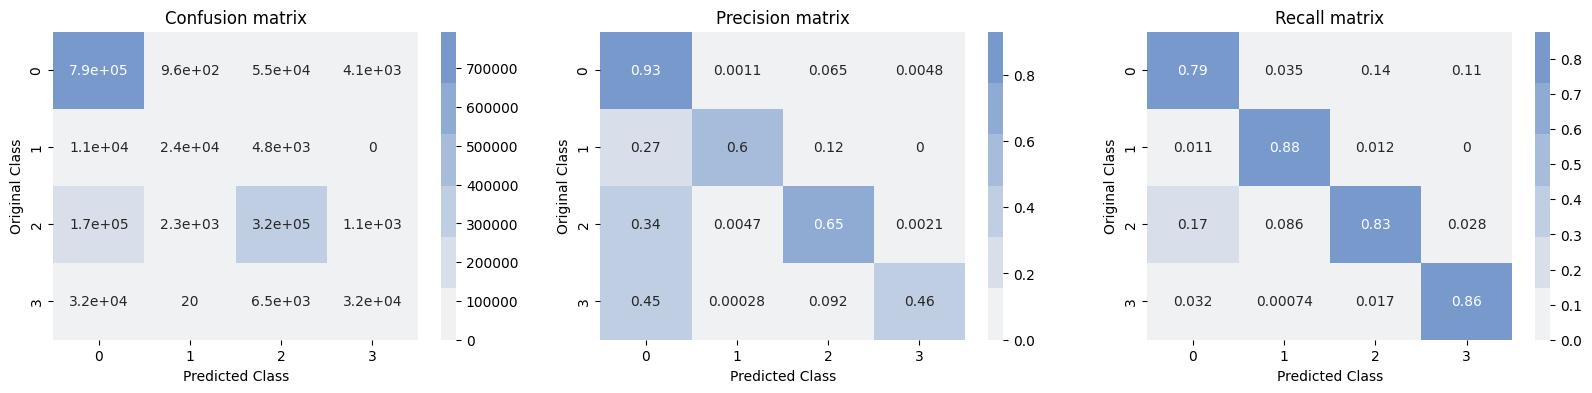

In [69]:
# predict on train and test data
y_train_pred = clf_lgbm.predict_proba(X_train)
y_test_pred = clf_lgbm.predict_proba(X_test)
print("Log loss on Train Data using LGBM Model", log_loss(y_train, y_train_pred))
print("Log loss on Test Data using  LGBM Model", log_loss(y_test, y_test_pred))


# plot confusion, precision and recall matrix
test_p_val = clf_lgbm.predict(X_test)
plot_confusion_matrix(y_test, test_p_val)

There was a significant improvement in the log loss for the models and we achieved a test log loss of 0.1042.

However, we need to consider improving the precision and recall scores as well. Because in the problem we are trying to solve, errors can be very expensive, we need to be able to predict all the cognitive cases correctly.

During EDA we noticed that our data is imbalanced. Let us try to train our models by adding balanced class weights.

### 4.8 Logistic regression with class balance

In [22]:
# training and  hyperparameter tuning logistic regression
log_reg = LogisticRegression(class_weight="balanced", n_jobs=-1, max_iter=1500)
parameters = {
    'C': list(np.arange(0.001,10,0.01)),
    'penalty': ['l1', 'l2']
}
clf_lr = RandomizedSearchCV(log_reg, param_distributions=parameters, verbose = 1)
clf_lr.fit(X_train , y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                                max_iter=1500, n_jobs=-1),
                   param_distributions={'C': [0.001, 0.011,
                                              0.020999999999999998,
                                              0.030999999999999996,
                                              0.040999999999999995,
                                              0.05099999999999999,
                                              0.06099999999999999, 0.071,
                                              0.08099999999999999,
                                              0.09099999999999998,
                                              0.10099999999999998,
                                              0.11099999999999999,
                                              0.12099999999999998,
                                              0.13099999999999998, 0.141,
                                              0.15099999999999997,
                                              0.16099999999999998,
                                              0.17099999999999999,
                                              0.18099999999999997,
                                              0.19099999999999998,
                                              0.20099999999999996,
                                              0.21099999999999997,
                                              0.22099999999999997,
                                              0.23099999999999996,
                                              0.24099999999999996,
                                              0.25099999999999995,
                                              0.26099999999999995,
                                              0.27099999999999996,
                                              0.28099999999999997, 0.291, ...],
                                        'penalty': ['l1', 'l2']},
                   verbose=1)

In [23]:
pd.DataFrame(clf_lr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,28.962868,2.728545,0.114163,0.023902,l2,4.321,"{'penalty': 'l2', 'C': 4.321}",0.089971,0.091176,0.089704,0.089908,0.091476,0.090447,0.000729,1
1,0.077196,0.005315,0.000000,0.000000,l1,7.101,"{'penalty': 'l1', 'C': 7.100999999999999}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
2,28.713550,2.709657,0.100342,0.001128,l2,5.541,"{'penalty': 'l2', 'C': 5.5409999999999995}",0.089971,0.091176,0.089704,0.089908,0.091476,0.090447,0.000729,1
3,0.079484,0.005596,0.000000,0.000000,l1,1.131,"{'penalty': 'l1', 'C': 1.1309999999999998}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
4,29.233107,2.809325,0.111088,0.019529,l2,1.431,"{'penalty': 'l2', 'C': 1.4309999999999996}",0.089971,0.091176,0.089704,0.089908,0.091476,0.090447,0.000729,1
5,29.535570,2.486477,0.101375,0.001778,l2,8.671,"{'penalty': 'l2', 'C': 8.670999999999998}",0.089971,0.091176,0.089704,0.089908,0.091476,0.090447,0.000729,1
6,29.238706,2.985056,0.113467,0.021397,l2,5.751,"{'penalty': 'l2', 'C': 5.7509999999999994}",0.089971,0.091176,0.089704,0.089908,0.091476,0.090447,0.000729,1
7,0.092884,0.003877,0.000000,0.000000,l1,1.611,"{'penalty': 'l1', 'C': 1.6109999999999995}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
8,0.091835,0.001197,0.000000,0.000000,l1,4.021,"{'penalty': 'l1', 'C': 4.021}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
9,29.492192,2.431691,0.105356,0.003109,l2,2.071,"{'penalty': 'l2', 'C': 2.0709999999999997}",0.089971,0.091176,0.089704,0.089908,0.091476,0.090447,0.000729,1


In [24]:
clf_lr.best_params_

{'penalty': 'l2', 'C': 4.321}

In [25]:
y_train_pred = clf_lr.predict_proba(X_train)
y_test_pred = clf_lr.predict_proba(X_test)

Log loss on Train Data using logistic regression Model 1.3554940734351546
Log loss on Test Data using  logistic regression Model 1.3549239857054325


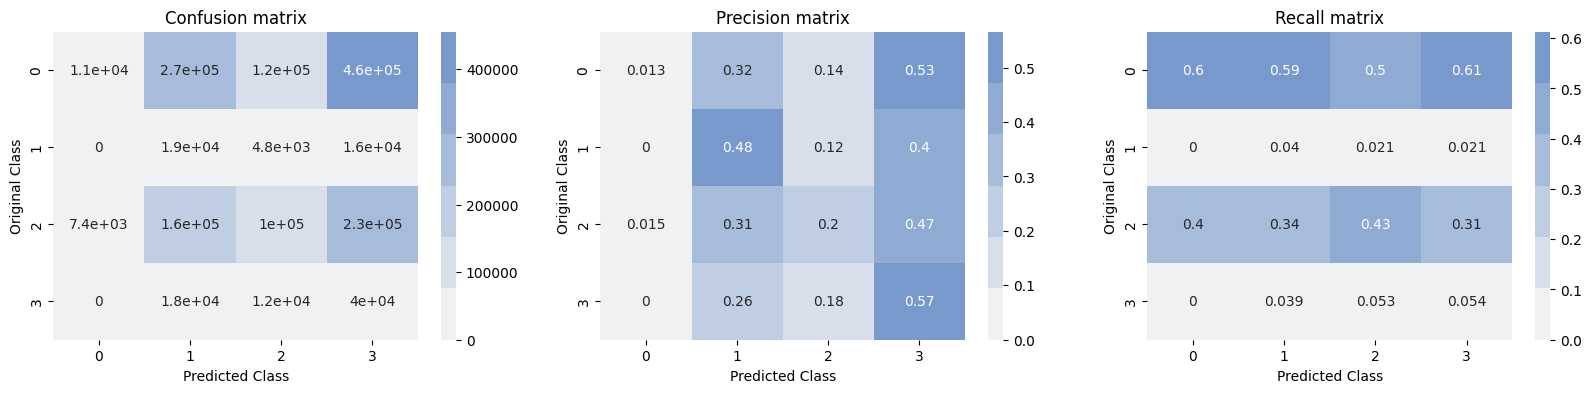

In [26]:
# predict on train and test data
y_train_pred = clf_lr.predict_proba(X_train)
y_test_pred = clf_lr.predict_proba(X_test)
print("Log loss on Train Data using logistic regression Model", log_loss(y_train, y_train_pred))
print("Log loss on Test Data using  logistic regression Model", log_loss(y_test, y_test_pred))


# plot confusion, precision and recall matrix
test_p_val = clf_lr.predict(X_test)
plot_confusion_matrix(y_test, test_p_val)

### 4.9 Random Forest with class balance

In [9]:
# hyper parameter tunning
params = {"n_estimators" : list(range(10,500)),          
        "criterion" : ["gini","entropy"],
        "min_samples_split" : list(range(2,100)),     
        "min_samples_leaf" : list(range(1,100)),
          }

rf = RandomForestClassifier(class_weight="balanced", n_jobs=-1)
clf_rf_v2 = RandomizedSearchCV(rf,param_distributions=params,verbose=1)
clf_rf_v2.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30, ...],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19, 20,
                                                              21, 22, 23, 24,
                                                              25, 26, 27, 28,
                                                              29, 30, 31, ...],
                                        'n_estimators': [10, 11, 12, 13, 14, 15,
                                                         16, 17, 18, 19, 20, 21,
                                                         22, 23, 24, 25, 26, 27,
                                                         28, 29, 30, 31, 32, 33,
                                                         34, 35, 36, 37, 38, 39, ...]},
                   verbose=1)

In [10]:
pd.DataFrame(clf_rf_v2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,294.076853,1.615141,4.257345,0.033698,464,78,15,gini,"{'n_estimators': 464, 'min_samples_split': 78,...",0.936112,0.936724,0.937032,0.936506,0.936885,0.936652,0.000321,2
1,467.478560,1.259287,3.938031,0.103435,484,49,51,entropy,"{'n_estimators': 484, 'min_samples_split': 49,...",0.911446,0.911979,0.912281,0.911703,0.911547,0.911791,0.000304,4
2,89.342616,0.696493,1.238070,0.010555,135,45,63,gini,"{'n_estimators': 135, 'min_samples_split': 45,...",0.899012,0.899699,0.900003,0.899304,0.899347,0.899473,0.000343,6
3,148.130788,0.916921,1.296727,0.027264,155,19,94,entropy,"{'n_estimators': 155, 'min_samples_split': 19,...",0.877362,0.878228,0.878582,0.877660,0.877019,0.877770,0.000568,9
4,258.273984,0.431986,3.049767,0.040024,429,95,86,gini,"{'n_estimators': 429, 'min_samples_split': 95,...",0.882914,0.883907,0.884195,0.883364,0.882934,0.883463,0.000515,8
5,464.403115,1.863516,3.742273,0.039852,485,36,62,entropy,"{'n_estimators': 485, 'min_samples_split': 36,...",0.901479,0.902119,0.902230,0.901516,0.901683,0.901805,0.000311,5
6,142.682127,0.532688,1.292100,0.047627,142,9,72,entropy,"{'n_estimators': 142, 'min_samples_split': 9, ...",0.892833,0.893803,0.893649,0.893012,0.892894,0.893238,0.000405,7
7,481.960527,1.883359,4.202003,0.049845,499,78,45,entropy,"{'n_estimators': 499, 'min_samples_split': 78,...",0.917485,0.917881,0.918260,0.917661,0.917676,0.917792,0.000265,3
8,144.669021,1.129897,1.228780,0.017985,149,11,95,entropy,"{'n_estimators': 149, 'min_samples_split': 11,...",0.876803,0.877468,0.877861,0.876809,0.876476,0.877084,0.000505,10
9,308.428299,1.405864,2.998767,0.028299,310,71,18,entropy,"{'n_estimators': 310, 'min_samples_split': 71,...",0.939023,0.939402,0.939722,0.939289,0.939317,0.939350,0.000225,1


In [11]:
clf_rf_v2.best_params_

{'n_estimators': 310,
 'min_samples_split': 71,
 'min_samples_leaf': 18,
 'criterion': 'entropy'}

Log loss on Train Data using Random Forest Model 0.15562965188882505
Log loss on Test Data using  Random Forest Model 0.17030564342633447


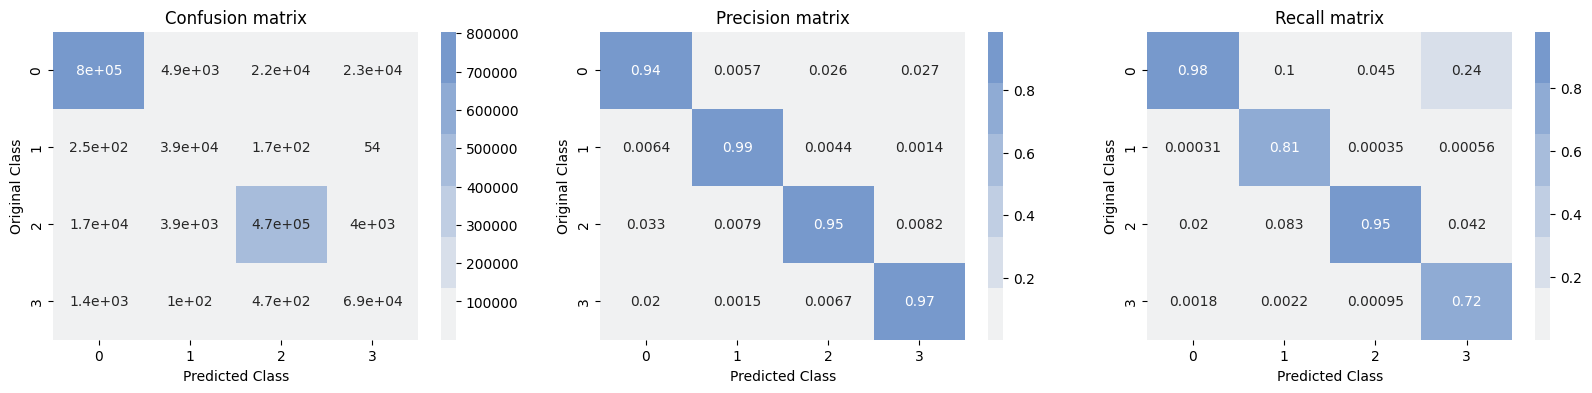

In [15]:
# predict on train and test data
y_train_pred = clf_rf_v2.predict_proba(X_train)
y_test_pred = clf_rf_v2.predict_proba(X_test)
print("Log loss on Train Data using Random Forest Model", log_loss(y_train, y_train_pred))
print("Log loss on Test Data using  Random Forest Model", log_loss(y_test, y_test_pred))

# plot confusion, precision and recall matrix
test_p_val = clf_rf_v2.predict(X_test)
plot_confusion_matrix(y_test, test_p_val)

### 4.10 LGBM with class balance

In [16]:
#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
# hyper parameter tunning
params = {"n_estimators":list(range(10,500)),          
        "num_leaves" : range(1,50),          
        "learning_rate" : [1e-4,0.0001,0.001,0.01,0.1],     
        "bagging_fraction" : list(np.arange(0.0,1.0,0.1)),                    
        "colsample_bytree" : list(np.arange(0.0,1.0,0.1)),  
        'min_data_in_leaf':list(range(10,100))
          }

In [17]:
lgbm = lgb.LGBMClassifier(class_weight="balanced",n_jobs=-1) 
clf_lgbm = RandomizedSearchCV(lgbm,param_distributions=params,verbose=1)

In [18]:
clf_lgbm.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fracti

[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_fraction is set

RandomizedSearchCV(estimator=LGBMClassifier(class_weight='balanced'),
                   param_distributions={'bagging_fraction': [0.0, 0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5,
                                                             0.6000000000000001,
                                                             0.7000000000000001,
                                                             0.8, 0.9],
                                        'colsample_bytree': [0.0, 0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5,
                                                             0.6000000000000001,
                                                             0.7000000000000001,
                                                             0.8, 0.9],
                                        'learning_rate': [0.0001, 0.0001, 0.001,
                                                          0.01, 0.1],
                                        'min_data_in_leaf': [10, 11, 12, 13, 14,
                                                             15, 16, 17, 18, 19,
                                                             20, 21, 22, 23, 24,
                                                             25, 26, 27, 28, 29,
                                                             30, 31, 32, 33, 34,
                                                             35, 36, 37, 38, 39, ...],
                                        'n_estimators': [10, 11, 12, 13, 14, 15,
                                                         16, 17, 18, 19, 20, 21,
                                                         22, 23, 24, 25, 26, 27,
                                                         28, 29, 30, 31, 32, 33,
                                                         34, 35, 36, 37, 38, 39, ...],
                                        'num_leaves': range(1, 50)},
                   verbose=1)

In [19]:
pd.DataFrame(clf_lgbm.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_min_data_in_leaf,param_learning_rate,param_colsample_bytree,param_bagging_fraction,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,41.445623,1.516877,3.583263,0.028059,18,453,12,0.0001,0.7,0.3,"{'num_leaves': 18, 'n_estimators': 453, 'min_d...",0.425350,0.417556,0.408376,0.417935,0.432893,0.420422,0.008238,5
1,3.423922,0.059452,0.225580,0.003266,43,23,67,0.01,0.4,0.7,"{'num_leaves': 43, 'n_estimators': 23, 'min_da...",0.538017,0.528190,0.527170,0.529447,0.479141,0.520393,0.020981,2
2,15.711425,0.260685,1.299890,0.017794,40,155,57,0.01,0.3,0.4,"{'num_leaves': 40, 'n_estimators': 155, 'min_d...",0.358854,0.368168,0.369792,0.372996,0.381295,0.370221,0.007266,6
3,8.763692,0.083471,0.659384,0.011381,34,78,78,0.1,0.7,0.4,"{'num_leaves': 34, 'n_estimators': 78, 'min_da...",0.668267,0.667768,0.663669,0.662495,0.670237,0.666487,0.002924,1
4,9.784599,0.605262,0.399158,0.020904,2,205,98,0.0001,0.5,0.9,"{'num_leaves': 2, 'n_estimators': 205, 'min_da...",0.111342,0.125782,0.125612,0.125052,0.123034,0.122164,0.005499,10
5,32.165361,8.098220,2.643921,0.004622,19,303,68,0.0001,0.7,0.7,"{'num_leaves': 19, 'n_estimators': 303, 'min_d...",0.415958,0.426676,0.426200,0.435050,0.425610,0.425899,0.006055,4
6,7.169474,0.140436,0.308733,0.002770,23,77,91,0.001,0.2,0.2,"{'num_leaves': 23, 'n_estimators': 77, 'min_da...",0.335500,0.332392,0.327746,0.326173,0.353558,0.335074,0.009818,8
7,6.786822,1.656432,0.278880,0.003525,18,68,51,0.001,0.3,0.8,"{'num_leaves': 18, 'n_estimators': 68, 'min_da...",0.287161,0.294211,0.292286,0.289696,0.301774,0.293026,0.004979,9
8,23.223364,0.368206,2.445198,0.012168,31,253,29,0.001,0.1,0.1,"{'num_leaves': 31, 'n_estimators': 253, 'min_d...",0.339264,0.348953,0.340676,0.346465,0.351606,0.345393,0.004738,7
9,8.497662,2.054368,0.420503,0.009138,42,61,60,0.001,0.5,0.6,"{'num_leaves': 42, 'n_estimators': 61, 'min_da...",0.472998,0.464389,0.476161,0.469768,0.537515,0.484166,0.026957,3


In [20]:
clf_lgbm.best_params_

{'num_leaves': 34,
 'n_estimators': 78,
 'min_data_in_leaf': 78,
 'learning_rate': 0.1,
 'colsample_bytree': 0.7000000000000001,
 'bagging_fraction': 0.4}

Log loss on Train Data using LGBM Model 0.6721134091503779
Log loss on Test Data using  LGBM Model 0.6722902292029918


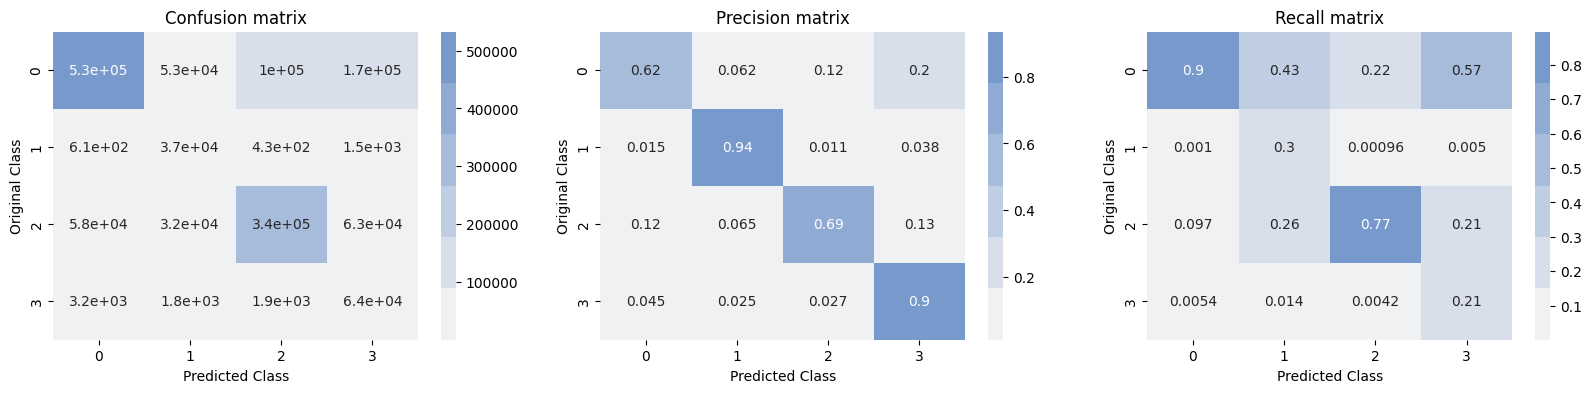

In [21]:
# predict on train and test data
y_train_pred = clf_lgbm.predict_proba(X_train)
y_test_pred = clf_lgbm.predict_proba(X_test)
print("Log loss on Train Data using LGBM Model", log_loss(y_train, y_train_pred))
print("Log loss on Test Data using  LGBM Model", log_loss(y_test, y_test_pred))


# plot confusion, precision and recall matrix
test_p_val = clf_lgbm.predict(X_test)
plot_confusion_matrix(y_test, test_p_val)

1. For logistic regression, there was a huge difference in precision and recall. Previously no points were correctly predicted for class 1 and 3.
2. For Random forest, significant improvement in precision for class 3 but the recall of class 3 and 1 reduced.
3. For LGBM, there was an improvement in precision but the recal reduced.

# 5. Results
### 5.1 With 3 Features
|Model|Train Loss|Test Loss|
|---|---|---|
|Random Model|1.6448|1.6457|
|k-NN|6.6613e-16|1.2603|
|Logistic Regression|0.9032|0.9031|
|Random Forest|0.1359|0.1653|
|LGBM|0.5349|0.5343|
### 5.2 With 4 Features
|Model|Train Loss|Test Loss|
|---|---|---|
|Random Model|1.6451|1.6455|
|k-NN|0.0163|0.5411|
|Logistic Regression|0.8834|0.8830|
|Random Forest|0.0828|0.1042|
|LGBM|0.4353|0.4357|
### 5.3 With 4 Features and class balance
|Model|Train Loss|Test Loss|
|---|---|---|
|Logistic Regression|1.3554|1.3549|
|Random Forest|0.1556|0.1703|
|LGBM|0.6721|0.6722|

In our problem, we need to focus on detecting all the cognitive cases correctly. Hence, we need model with best Recall.

Random forest with 4 features gave us the best log loss and recall matrix

In [70]:
# saving best model
pickle.dump(clf_rf, open("random_forest", 'wb'))